<a href="https://colab.research.google.com/github/e-chong/Singapore-Ship-Detection/blob/master/Read_and_resize_Kaggle_ships.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download data from the Kaggle competition "Ships in Satellite Imagery".

https://www.kaggle.com/rhammell/ships-in-satellite-imagery

https://towardsdatascience.com/setting-up-kaggle-in-google-colab-ebb281b61463

Install and load packages

In [0]:
%%capture
!pip install kaggle
!pip install tifffile

In [0]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.transform import resize
import tifffile as tiff

Make a directory called `.kaggle` that will store the Kaggle API Key

In [0]:
!mkdir .kaggle

Create a json with the API key

In [0]:
token = {"username":"echong91","key":"635179943a477c0e17ef3b3961910251"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

Copy the API key to the a folder in the root directory called `.kaggle`.

For some reason, this needs to be run twice to work properly.

In [5]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}


cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
- path is now set to: {/content}


In [0]:
# !chmod 600 /root/.kaggle/kaggle.json

Download the dataset. It is now in the working directory.

In [7]:
!kaggle datasets download -d rhammell/ships-in-satellite-imagery -p /content

 87% 161M/185M [00:02<00:00, 68.6MB/s]
100% 185M/185M [00:02<00:00, 70.1MB/s]


In [8]:
!ls

sample_data  ships-in-satellite-imagery.zip


Unzip data

In [0]:
%%capture
!unzip \*.zip

In [10]:
!ls

sample_data  scenes  ships-in-satellite-imagery.zip  shipsnet  shipsnet.json


Read the json file as a pandas dataframe and inspect.

**Do we actually need the dataframe?**

In [0]:
with open('shipsnet.json') as data_file:
    kg_ships_dict = json.load(data_file)

In [12]:
kg_ships_df = pd.DataFrame(kg_ships_dict)
kg_ships_df.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


Read image data as numpy array and reshape as 80x80x3

In [0]:
kg_ships_data = np.array(kg_ships_dict['data']).astype('uint8')

In [14]:
kg_ships_data[0]

array([82, 89, 91, ..., 86, 88, 89], dtype=uint8)

In [15]:
n_spectrum = 3 # color channel (RGB)
weight = 80
height = 80
X = kg_ships_data.reshape([-1, n_spectrum, weight, height])
X = np.moveaxis(X, 1, 3)
X[0].shape

(80, 80, 3)

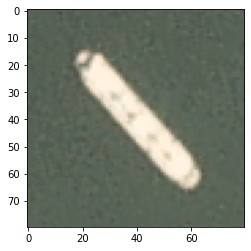

In [16]:
plt.imshow(X[0]);

Resize images to match Sentinel-2 patches

Note that there are several interpolation methods we should experiment with: 
- Discussion: https://stackoverflow.com/questions/48121916/numpy-resize-rescale-image
- "Order" parameter for interpolation: https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize
- Definitions for "Order" parameter: https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.warp

In [0]:
patch_size = [50, 50]

In [0]:
kg_ships_resize = np.zeros([X.shape[0],
                            patch_size[0],
                            patch_size[1],
                            X.shape[3]])

for img in range(X.shape[0]):
  kg_ships_resize[img] = resize(X[img], patch_size)

In [19]:
kg_ships_resize.shape

(4000, 50, 50, 3)

Resized images have been rescaled 0 to 1

In [20]:
kg_ships_resize[0]

array([[[0.33427451, 0.37815686, 0.32443137],
        [0.34780392, 0.38807843, 0.34309804],
        [0.34058824, 0.38235294, 0.33137255],
        ...,
        [0.35176471, 0.39745098, 0.33980392],
        [0.35541176, 0.40717647, 0.34270588],
        [0.32984314, 0.3772549 , 0.32584314]],

       [[0.35345098, 0.394     , 0.34380392],
        [0.33670588, 0.38298039, 0.33270588],
        [0.33568627, 0.37882353, 0.32784314],
        ...,
        [0.32431373, 0.36607843, 0.31470588],
        [0.33301961, 0.38082353, 0.32447059],
        [0.3492549 , 0.3914902 , 0.33921569]],

       [[0.32666667, 0.37372549, 0.32411765],
        [0.34137255, 0.38666667, 0.33745098],
        [0.33823529, 0.37941176, 0.33235294],
        ...,
        [0.33823529, 0.3745098 , 0.32745098],
        [0.33196078, 0.36764706, 0.31509804],
        [0.34      , 0.38333333, 0.33294118]],

       ...,

       [[0.35098039, 0.38235294, 0.33921569],
        [0.3545098 , 0.38764706, 0.3427451 ],
        [0.34803922, 0

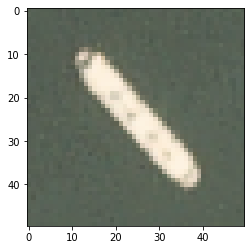

In [21]:
plt.imshow(kg_ships_resize[0]);